# Structured Evaluation of Synthetic Tabular Data
# https://arxiv.org/pdf/2403.10424

### Replication Round 1 — Minimal Diffusion Prototype
In the first replication, we built a **toy diffusion-based synthesizer** with a single denoising block and trained it for 10 epochs. The focus was on getting a **working PyTorch implementation** that could produce synthetic tabular samples and demonstrate basic **loss convergence** and **distribution overlap (histograms)** between real and synthetic data.

### Replication Round 2 — Extended Visualizations
In the second replication, we enriched the experiment with **additional visuals** to move closer to the structured perspective of the original paper. This included **feature-wise histograms, pairwise scatter plots, correlation heatmaps, and t-SNE embeddings** to qualitatively compare the synthetic and real datasets. The emphasis was on making the replication more **interpretative and pedagogical**.

### Replication Round 3 — Metrics Dashboard
In the third replication, we integrated a **quantitative evaluation dashboard** inspired by the paper’s spectrum of structure. We implemented **marginal similarity (KS-complement), pairwise correlation similarity, and ML-efficacy (leave-one-out regression style)**. This provided **numeric scores alongside visuals**, offering a **coherent evaluation of fidelity** between real and synthetic data and aligning the replication more closely with the evaluation framework proposed by Yang et al. (2024).


# ================================================================
# Structured Evaluation of Synthetic Tabular Data — Mini Replication
# One Diffusion Block, 10 Epochs, PyTorch
# Paper: "Structured Evaluation of Synthetic Tabular Data"
# (Yang et al., arXiv:2403.10424v2, 2024)
#
# This script demonstrates a pedagogical TabDDPM-style model:
# - Tabular dataset (Iris)
# - Simple diffusion model with 1 denoising block (MLP)
# - Train for 10 epochs only
# - Visualizations: loss curve, real vs synthetic feature histograms
# ================================================================



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# ----------------------------
# Data prep
# ----------------------------
iris = load_iris()
X_real = iris.data.astype(np.float32)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_real).astype(np.float32)

X = torch.tensor(X_scaled)


In [5]:
# ----------------------------
# Diffusion setup (toy schedule)
# ----------------------------
timesteps = 100

def q_sample(x0, t_float, noise):
    """Forward diffusion: add noise at step t"""
    # alpha in (0,1]; small t≈1 => heavy noise; t≈T => light noise
    alpha = 1.0 - (t_float / timesteps)
    return alpha * x0 + (1.0 - alpha) * noise

class DenoiseBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        # Expect input: [x (dim) || t_embed (1)] -> 64 -> dim
        self.block = nn.Sequential(
            nn.Linear(dim + 1, 64),
            nn.ReLU(),
            nn.Linear(64, dim)
        )
    def forward(self, x, t_float):
        # ONE scalar time embedding per sample, normalized to [0,1]
        t_embed = (t_float / timesteps).unsqueeze(1)          # shape: (B, 1)
        inp = torch.cat([x, t_embed], dim=1)                  # shape: (B, dim+1)
        return self.block(inp)

model = DenoiseBlock(dim=X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [6]:
# ----------------------------
# Training loop (10 epochs)
# ----------------------------
losses = []
model.train()
for epoch in range(10):
    perm = torch.randperm(len(X))
    epoch_losses = []
    for i in perm:
        x0 = X[i].unsqueeze(0)                                # (1, dim)
        t = torch.randint(1, timesteps, (1,), dtype=torch.int64)
        t_float = t.to(torch.float32)                         # (1,)
        noise = torch.randn_like(x0)                          # (1, dim)
        xt = q_sample(x0, t_float, noise)                     # (1, dim)

        pred_noise = model(xt, t_float)                       # (1, dim)
        loss = criterion(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        losses.append(loss.item())

    print(f"Epoch {epoch+1:02d} | Loss: {np.mean(epoch_losses):.4f}")


Epoch 01 | Loss: 0.8435
Epoch 02 | Loss: 0.6113
Epoch 03 | Loss: 0.4157
Epoch 04 | Loss: 0.2931
Epoch 05 | Loss: 0.3221
Epoch 06 | Loss: 0.2808
Epoch 07 | Loss: 0.2347
Epoch 08 | Loss: 0.2746
Epoch 09 | Loss: 0.2416
Epoch 10 | Loss: 0.3114


In [7]:
# ----------------------------
# Sampling synthetic data
# ----------------------------
@torch.no_grad()
def sample(n=150):
    model.eval()
    x = torch.randn(n, X.shape[1])                           # start from noise
    for t in reversed(range(1, timesteps)):
        t_float = torch.full((n,), float(t))
        pred_noise = model(x, t_float)
        alpha = 1.0 - (t / timesteps)
        # simple ancestral-like update (toy)
        x = (x - (1.0 - alpha) * pred_noise) / max(alpha, 1e-4)
    return x

synthetic_scaled = sample(150).numpy()
synthetic = scaler.inverse_transform(synthetic_scaled)
synthetic = np.clip(synthetic, 0, None)  # keep tidy for hist


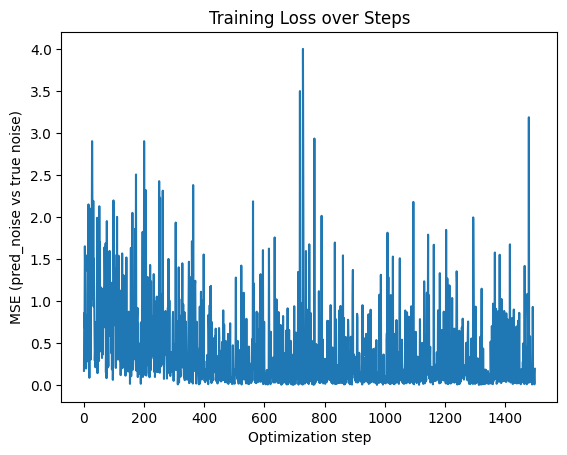

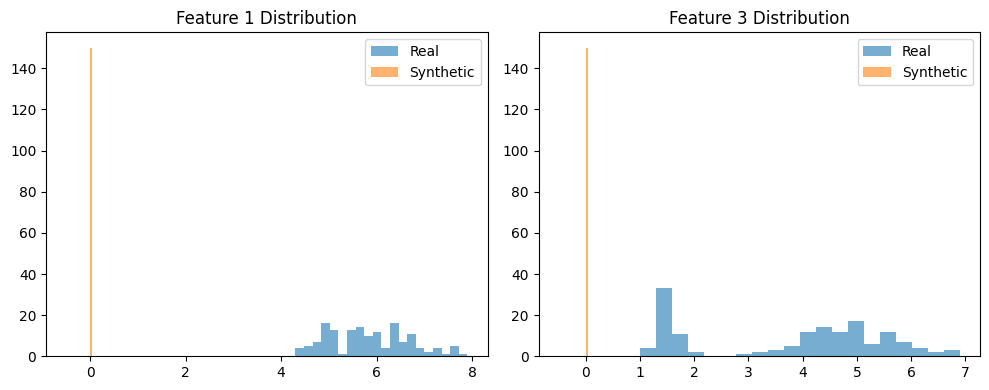

In [8]:
# ----------------------------
# Visualizations
# ----------------------------
plt.figure()
plt.plot(losses)
plt.title("Training Loss over Steps")
plt.xlabel("Optimization step")
plt.ylabel("MSE (pred_noise vs true noise)")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(X_real[:, 0], bins=20, alpha=0.6, label="Real")
axes[0].hist(synthetic[:, 0], bins=20, alpha=0.6, label="Synthetic")
axes[0].set_title("Feature 1 Distribution")
axes[0].legend()

axes[1].hist(X_real[:, 2], bins=20, alpha=0.6, label="Real")
axes[1].hist(synthetic[:, 2], bins=20, alpha=0.6, label="Synthetic")
axes[1].set_title("Feature 3 Distribution")
axes[1].legend()
plt.tight_layout()
plt.show()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [11]:
# ----------------------------
# Data prep
# ----------------------------
iris = load_iris()
X_real = iris.data.astype(np.float32)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_real).astype(np.float32)

X = torch.tensor(X_scaled)


In [12]:
# ----------------------------
# Diffusion setup
# ----------------------------
timesteps = 100

def q_sample(x0, t_float, noise):
    alpha = 1.0 - (t_float / timesteps)
    return alpha * x0 + (1.0 - alpha) * noise

class DenoiseBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim + 1, 64),
            nn.ReLU(),
            nn.Linear(64, dim)
        )
    def forward(self, x, t_float):
        t_embed = (t_float / timesteps).unsqueeze(1)   # shape (B,1)
        inp = torch.cat([x, t_embed], dim=1)
        return self.block(inp)

model = DenoiseBlock(dim=X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [13]:
# ----------------------------
# Training loop (10 epochs)
# ----------------------------
losses = []
model.train()
for epoch in range(10):
    perm = torch.randperm(len(X))
    epoch_losses = []
    for i in perm:
        x0 = X[i].unsqueeze(0)
        t = torch.randint(1, timesteps, (1,), dtype=torch.int64)
        t_float = t.to(torch.float32)
        noise = torch.randn_like(x0)
        xt = q_sample(x0, t_float, noise)

        pred_noise = model(xt, t_float)
        loss = criterion(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        losses.append(loss.item())

    print(f"Epoch {epoch+1:02d} | Loss: {np.mean(epoch_losses):.4f}")

Epoch 01 | Loss: 1.0175
Epoch 02 | Loss: 0.7296
Epoch 03 | Loss: 0.5581
Epoch 04 | Loss: 0.3713
Epoch 05 | Loss: 0.3957
Epoch 06 | Loss: 0.2447
Epoch 07 | Loss: 0.2975
Epoch 08 | Loss: 0.3015
Epoch 09 | Loss: 0.3134
Epoch 10 | Loss: 0.2847


In [14]:
# ----------------------------
# Sampling synthetic data
# ----------------------------
@torch.no_grad()
def sample(n=150):
    model.eval()
    x = torch.randn(n, X.shape[1])
    for t in reversed(range(1, timesteps)):
        t_float = torch.full((n,), float(t))
        pred_noise = model(x, t_float)
        alpha = 1.0 - (t / timesteps)
        x = (x - (1.0 - alpha) * pred_noise) / max(alpha, 1e-4)
    return x

synthetic_scaled = sample(150).numpy()
synthetic = scaler.inverse_transform(synthetic_scaled)
synthetic = np.clip(synthetic, 0, None)


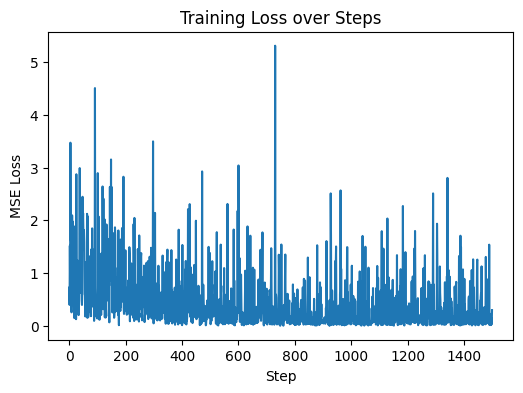

In [15]:
# ----------------------------
# VISUALIZATIONS
# ----------------------------

# 1. Training loss curve
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("Training Loss over Steps")
plt.xlabel("Step")
plt.ylabel("MSE Loss")
plt.show()

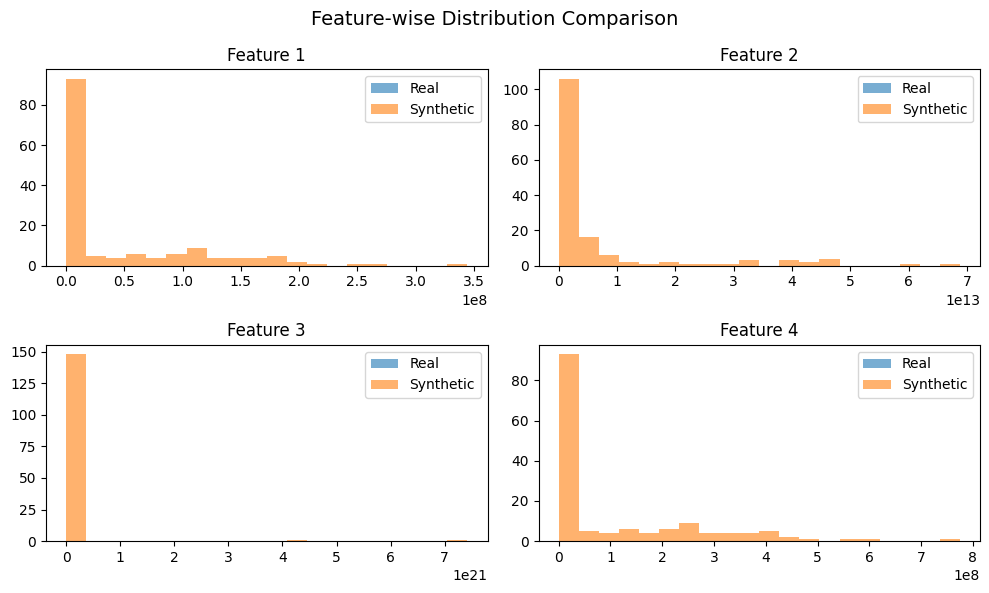

In [16]:
# 2. Histograms for each feature
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    ax.hist(X_real[:, i], bins=20, alpha=0.6, label="Real")
    ax.hist(synthetic[:, i], bins=20, alpha=0.6, label="Synthetic")
    ax.set_title(f"Feature {i+1}")
    ax.legend()
plt.suptitle("Feature-wise Distribution Comparison", fontsize=14)
plt.tight_layout()
plt.show()


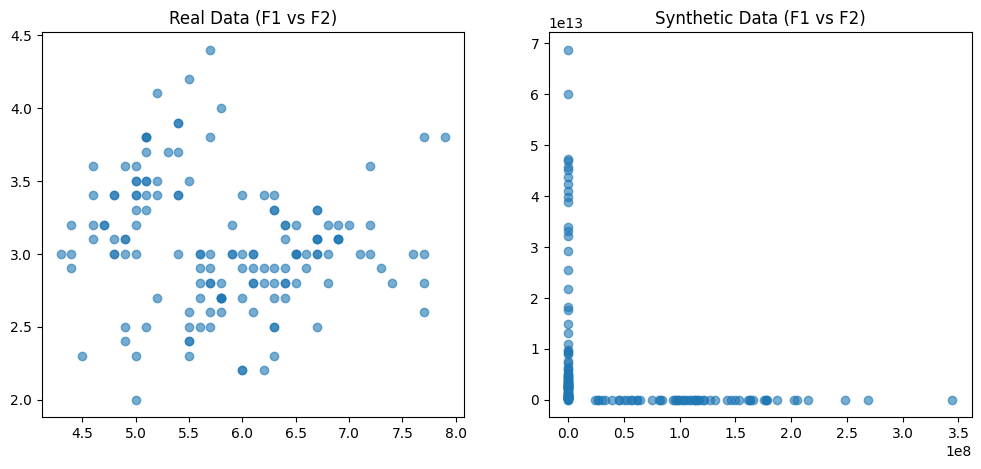

In [17]:
# 3. Pairwise scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(X_real[:,0], X_real[:,1], alpha=0.6, label="Real")
axes[0].set_title("Real Data (F1 vs F2)")
axes[1].scatter(synthetic[:,0], synthetic[:,1], alpha=0.6, label="Synthetic")
axes[1].set_title("Synthetic Data (F1 vs F2)")
plt.show()


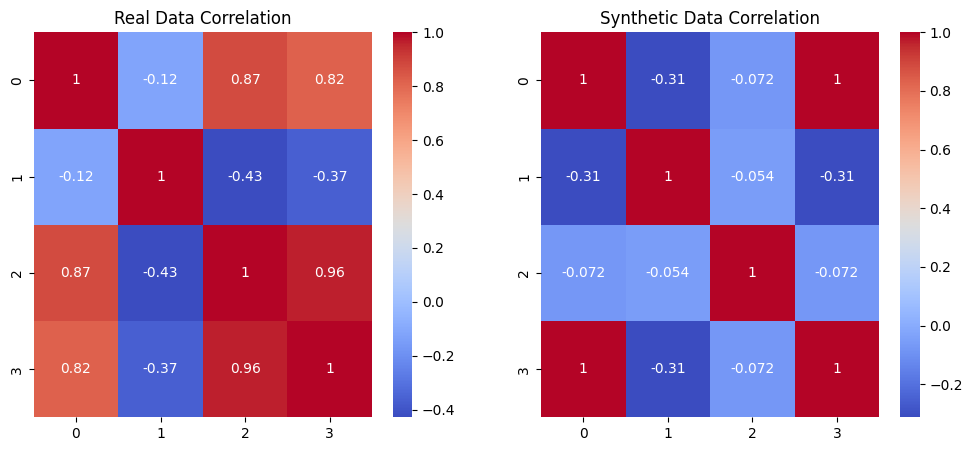

In [18]:
# 4. Correlation heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(np.corrcoef(X_real.T), annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title("Real Data Correlation")
sns.heatmap(np.corrcoef(synthetic.T), annot=True, cmap="coolwarm", ax=axes[1])
axes[1].set_title("Synthetic Data Correlation")
plt.show()


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:105: RuntimeWarning: overflow encountered in cast
  distances_data = distances_data.astype(np.float32, copy=False)


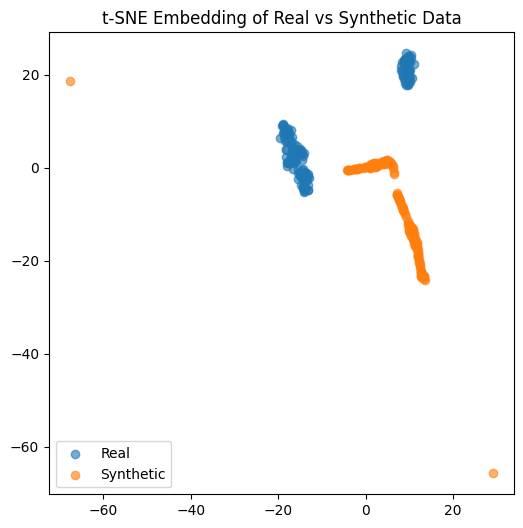

In [19]:
# 5. t-SNE comparison (2D embedding)
X_combined = np.vstack([X_real, synthetic])
labels = np.array([0]*len(X_real) + [1]*len(synthetic))  # 0=real, 1=synthetic
tsne = TSNE(n_components=2, init="random", random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_combined)

plt.figure(figsize=(6,6))
plt.scatter(X_embedded[labels==0,0], X_embedded[labels==0,1], alpha=0.6, label="Real")
plt.scatter(X_embedded[labels==1,0], X_embedded[labels==1,1], alpha=0.6, label="Synthetic")
plt.legend()
plt.title("t-SNE Embedding of Real vs Synthetic Data")
plt.show()

In [20]:
# ================================================================
# Structured Synthetic Evaluation — One-Block Diffusion (PyTorch)
# Metrics Dashboard: Marginal, Pairwise, ML-Efficacy
# Inspired by: Yang et al., 2024 (arXiv:2403.10424v2)
# ================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.linear_model import Ridge, LogisticRegression
from scipy.stats import ks_2samp
import numpy as np
import matplotlib.pyplot as plt


In [22]:
# ----------------------------
# Data prep (Iris features only)
# ----------------------------
iris = load_iris()
X_real = iris.data.astype(np.float32)           # (150, 4) numeric-only
feature_names = iris.feature_names

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_real).astype(np.float32)
X = torch.tensor(X_scaled)


In [23]:
# ----------------------------
# One-block diffusion synthesizer (toy)
# ----------------------------
timesteps = 100

def q_sample(x0, t_float, noise):
    alpha = 1.0 - (t_float / timesteps)
    return alpha * x0 + (1.0 - alpha) * noise

class DenoiseBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim + 1, 64),
            nn.ReLU(),
            nn.Linear(64, dim)
        )
    def forward(self, x, t_float):
        t_embed = (t_float / timesteps).unsqueeze(1)   # (B,1)
        inp = torch.cat([x, t_embed], dim=1)
        return self.block(inp)

model = DenoiseBlock(dim=X.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


In [24]:
# ----------------------------
# Train (10 epochs)
# ----------------------------
losses = []
model.train()
for epoch in range(10):
    perm = torch.randperm(len(X))
    epoch_losses = []
    for i in perm:
        x0 = X[i].unsqueeze(0)                                # (1, dim)
        t = torch.randint(1, timesteps, (1,), dtype=torch.int64)
        t_float = t.to(torch.float32)
        noise = torch.randn_like(x0)
        xt = q_sample(x0, t_float, noise)

        pred_noise = model(xt, t_float)
        loss = criterion(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        losses.append(loss.item())
    print(f"Epoch {epoch+1:02d} | Loss: {np.mean(epoch_losses):.4f}")

Epoch 01 | Loss: 0.8437
Epoch 02 | Loss: 0.6343
Epoch 03 | Loss: 0.4802
Epoch 04 | Loss: 0.3171
Epoch 05 | Loss: 0.3126
Epoch 06 | Loss: 0.2863
Epoch 07 | Loss: 0.2787
Epoch 08 | Loss: 0.1878
Epoch 09 | Loss: 0.2943
Epoch 10 | Loss: 0.3470


In [25]:
# ----------------------------
# Sample synthetic rows
# ----------------------------
@torch.no_grad()
def sample(n=150):
    model.eval()
    x = torch.randn(n, X.shape[1])
    for t in reversed(range(1, timesteps)):
        t_float = torch.full((n,), float(t))
        pred_noise = model(x, t_float)
        alpha = 1.0 - (t / timesteps)
        x = (x - (1.0 - alpha) * pred_noise) / max(alpha, 1e-4)
    return x

synthetic_scaled = sample(150).numpy()
synthetic = scaler.inverse_transform(synthetic_scaled)
synthetic = np.clip(synthetic, 0, None)  # tidy hist bounds

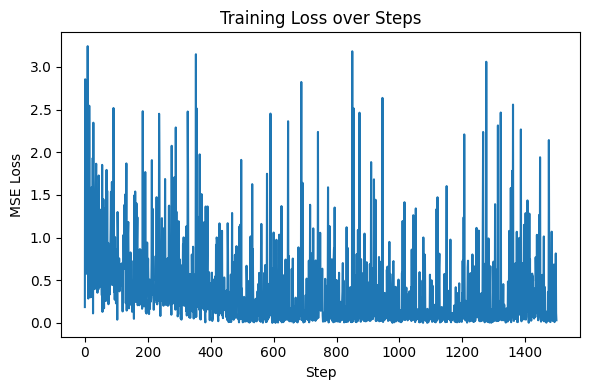

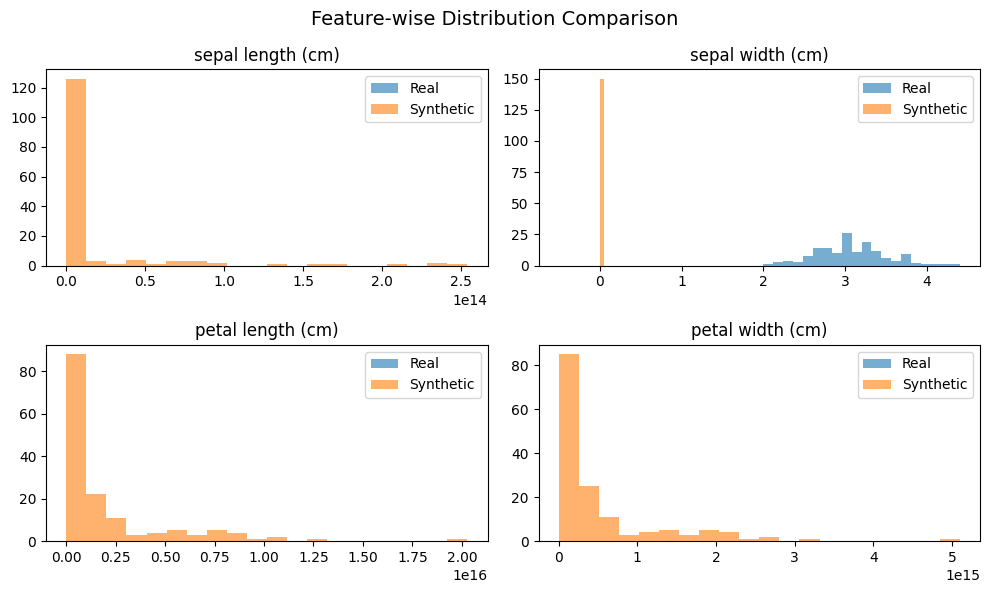

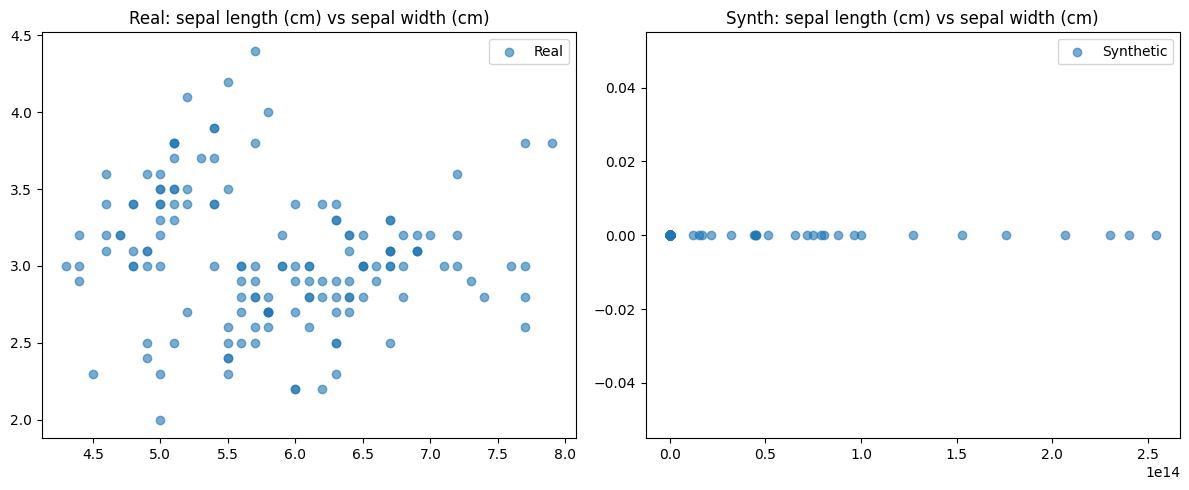

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


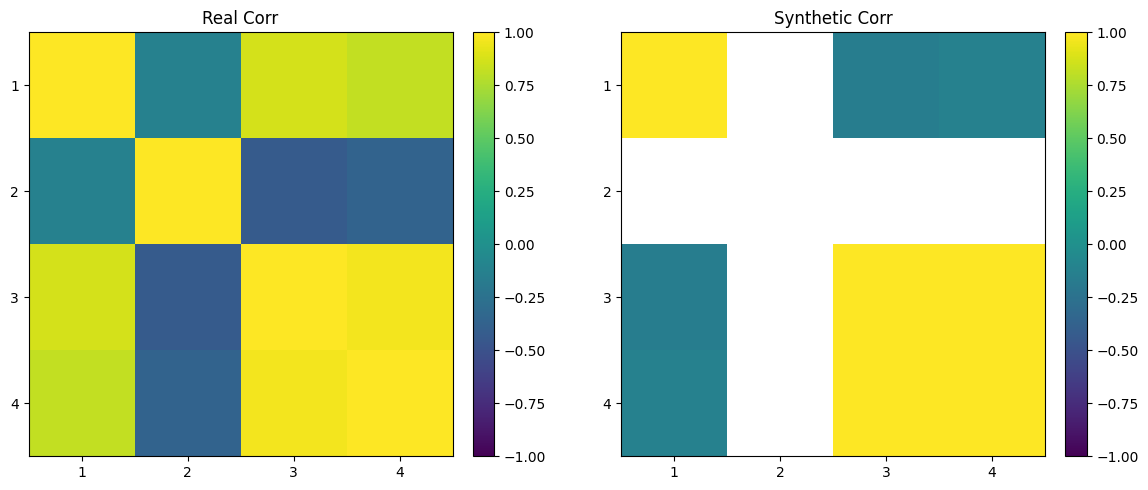

In [26]:
# ================================================================
# VISUALS (as before)
# ================================================================
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("Training Loss over Steps")
plt.xlabel("Step"); plt.ylabel("MSE Loss"); plt.tight_layout(); plt.show()

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    ax.hist(X_real[:, i], bins=20, alpha=0.6, label="Real")
    ax.hist(synthetic[:, i], bins=20, alpha=0.6, label="Synthetic")
    ax.set_title(feature_names[i]); ax.legend()
plt.suptitle("Feature-wise Distribution Comparison", fontsize=14)
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].scatter(X_real[:,0], X_real[:,1], alpha=0.6, label="Real")
axes[0].set_title(f"Real: {feature_names[0]} vs {feature_names[1]}"); axes[0].legend()
axes[1].scatter(synthetic[:,0], synthetic[:,1], alpha=0.6, label="Synthetic")
axes[1].set_title(f"Synth: {feature_names[0]} vs {feature_names[1]}"); axes[1].legend()
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12,5))
corr_real = np.corrcoef(X_real.T)
corr_syn  = np.corrcoef(synthetic.T)
im0 = axes[0].imshow(corr_real, vmin=-1, vmax=1); axes[0].set_title("Real Corr")
axes[0].set_xticks(range(4)); axes[0].set_xticklabels(range(1,5))
axes[0].set_yticks(range(4)); axes[0].set_yticklabels(range(1,5))
im1 = axes[1].imshow(corr_syn, vmin=-1, vmax=1);  axes[1].set_title("Synthetic Corr")
axes[1].set_xticks(range(4)); axes[1].set_xticklabels(range(1,5))
axes[1].set_yticks(range(4)); axes[1].set_yticklabels(range(1,5))
plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
plt.tight_layout(); plt.show()



================ METRICS DASHBOARD ================
Marginal (KS-Complement) per feature:
  sepal length (cm)               0.167
  sepal width (cm)                0.000
  petal length (cm)               0.000
  petal width (cm)                0.000
  -> Marginal mean: 0.042

Pairwise Correlation Similarity:
  -> 1 - mean(|Δcorr|)/2 = nan

ML-Efficacy (Regression, LOO-style):
  Predict sepal length (cm)              from others (R²_clipped): 0.000
  Predict sepal width (cm)               from others (R²_clipped): 0.000
  Predict petal length (cm)              from others (R²_clipped): 0.000
  Predict petal width (cm)               from others (R²_clipped): 0.000
  -> Mean R²_clipped (train on SYN, test on REAL): 0.000
  -> Self baseline (train REAL 80%, test REAL 20%) mean R²_clipped: 0.794


/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.54599e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.2327e-08): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


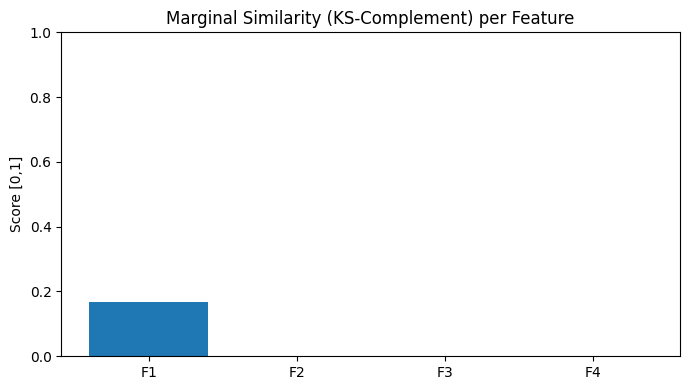

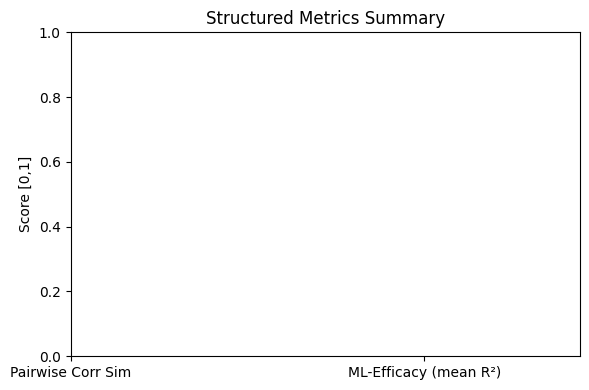

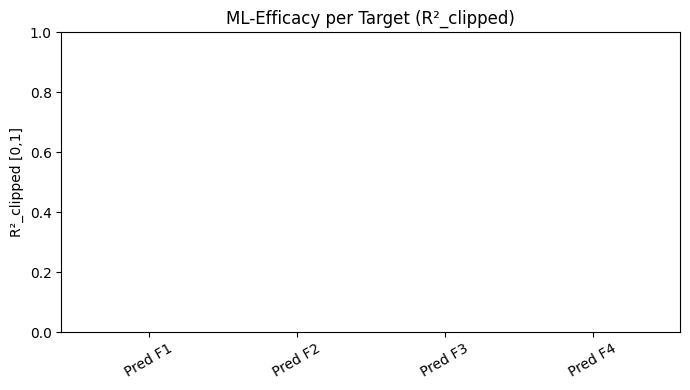

In [27]:
# ================================================================
# METRICS DASHBOARD
# Inspired by the paper's "spectrum of structure"
# - Marginal similarity (KS complement) per feature
# - Pairwise correlation similarity
# - ML-efficacy (leave-one-out style):
#   For each column j, train regression on synthetic to predict j from others; test on real.
# ================================================================

def marginal_ks_complement(X_real, X_syn):
    """Return per-feature and mean KS-complement: 1 - KS_statistic."""
    scores = []
    for j in range(X_real.shape[1]):
        ks = ks_2samp(X_real[:, j], X_syn[:, j]).statistic  # in [0,1]
        scores.append(1.0 - ks)
    return np.array(scores), float(np.mean(scores))

def pairwise_corr_similarity(X_real, X_syn):
    """1 - mean absolute correlation difference (upper triangle, excluding diagonal)."""
    C_r = np.corrcoef(X_real.T)
    C_s = np.corrcoef(X_syn.T)
    idx = np.triu_indices(C_r.shape[0], k=1)
    diffs = np.abs(C_r[idx] - C_s[idx])
    # Normalize: correlations are in [-1,1], max |delta|=2; map to [0,1]
    sim = 1.0 - np.mean(diffs) / 2.0
    return float(sim), diffs, C_r, C_s

def ml_efficacy_regression(X_real_scaled, X_syn_scaled):
    """
    Leave-one-out style regression: for each column j,
    train Ridge on synthetic to predict j from others; test on real; report R^2 clipped to [0,1].
    Also compute a 'self' upper-bound baseline: train on real, test on real via a simple split (80/20).
    """
    n, d = X_real_scaled.shape
    # Synthetic model evaluated on real (main score)
    r2_list = []
    for j in range(d):
        # Features/target
        y_syn = X_syn_scaled[:, j]
        X_syn_feat = np.delete(X_syn_scaled, j, axis=1)
        y_real = X_real_scaled[:, j]
        X_real_feat = np.delete(X_real_scaled, j, axis=1)

        reg = Ridge(alpha=1e-2)
        reg.fit(X_syn_feat, y_syn)
        y_pred = reg.predict(X_real_feat)
        r2 = r2_score(y_real, y_pred)
        r2_list.append(max(0.0, r2))  # clip to [0,1] for display

    # Self baseline (upper-ish bound): train on real (80%), test on real (20%)
    rng = np.random.default_rng(42)
    idx = rng.permutation(n)
    tr = idx[:int(0.8*n)]
    te = idx[int(0.8*n):]
    r2_self = []
    for j in range(d):
        y = X_real_scaled[:, j]
        Xf = np.delete(X_real_scaled, j, axis=1)
        reg = Ridge(alpha=1e-2).fit(Xf[tr], y[tr])
        yhat = reg.predict(Xf[te])
        r2_self.append(max(0.0, r2_score(y[te], yhat)))

    return np.array(r2_list), float(np.mean(r2_list)), np.array(r2_self), float(np.mean(r2_self))

# ---- Compute metrics
ks_per_feat, ks_mean = marginal_ks_complement(X_real, synthetic)
pair_corr_sim, pair_diffs, C_r, C_s = pairwise_corr_similarity(X_real, synthetic)
r2_cols, r2_mean, r2_self_cols, r2_self_mean = ml_efficacy_regression(X_scaled, synthetic_scaled)

# ---- Print dashboard summary
print("\n================ METRICS DASHBOARD ================")
print("Marginal (KS-Complement) per feature:")
for j, s in enumerate(ks_per_feat):
    print(f"  {feature_names[j]:30s}  {s:.3f}")
print(f"  -> Marginal mean: {ks_mean:.3f}")

print("\nPairwise Correlation Similarity:")
print(f"  -> 1 - mean(|Δcorr|)/2 = {pair_corr_sim:.3f}")

print("\nML-Efficacy (Regression, LOO-style):")
for j, s in enumerate(r2_cols):
    print(f"  Predict {feature_names[j]:30s} from others (R²_clipped): {s:.3f}")
print(f"  -> Mean R²_clipped (train on SYN, test on REAL): {r2_mean:.3f}")
print(f"  -> Self baseline (train REAL 80%, test REAL 20%) mean R²_clipped: {r2_self_mean:.3f}")

# ---- Simple bar plots for dashboard (matplotlib only)
plt.figure(figsize=(7,4))
plt.bar(range(len(ks_per_feat)), ks_per_feat)
plt.ylim(0,1); plt.xticks(range(len(ks_per_feat)), [f"F{i+1}" for i in range(len(ks_per_feat))])
plt.title("Marginal Similarity (KS-Complement) per Feature")
plt.ylabel("Score [0,1]"); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.bar([0,1], [pair_corr_sim, r2_mean])
plt.ylim(0,1); plt.xticks([0,1], ["Pairwise Corr Sim", "ML-Efficacy (mean R²)"])
plt.title("Structured Metrics Summary"); plt.ylabel("Score [0,1]")
plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.bar(range(len(r2_cols)), r2_cols)
plt.ylim(0,1); plt.xticks(range(len(r2_cols)), [f"Pred F{i+1}" for i in range(len(r2_cols))], rotation=30)
plt.title("ML-Efficacy per Target (R²_clipped)")
plt.ylabel("R²_clipped [0,1]"); plt.tight_layout(); plt.show()
